In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import GPy
import random
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error as mse
from emukit.core import ParameterSpace, ContinuousParameter
from emukit.model_wrappers import GPyModelWrapper
from emukit.bayesian_optimization.loops import BayesianOptimizationLoop
from emukit.bayesian_optimization.acquisitions import ExpectedImprovement, \
                                                      NegativeLowerConfidenceBound, \
                                                      MaxValueEntropySearch, \
                                                      ProbabilityOfImprovement
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split

In [2]:
def myplot(y_true_list, y_pred_list,var_list, title_str_list, color_list,region):
    fig, axes = plt.subplots(1, 2, figsize=(5.5*2, 4.5))
    fs = 18
    
    for i in range(len(axes)):
        axes[i].scatter(y_true_list[i], y_pred_list[i], alpha = 0.6, c = color_list[i])
        axes[i].plot(region,region, 'k--', alpha=0.75, zorder=0)
        axes[i].errorbar(y_true_list[i],y_pred_list[i], yerr = var_list[i], ms = 0, 
                 ls = '', capsize = 2, alpha = 0.6,
                 color = 'gray', zorder = 0)
        axes[i].set_xlabel('Ground Truth', fontsize = fs)
        axes[i].set_ylabel('Prediction', fontsize = fs)
        axes[i].set_xlim(region)
        axes[i].set_ylim(region)
        rmse = mse(y_true_list[i],y_pred_list[i],squared=False)
        title = title_str_list[i] + " (RMSE = %.3f)"%rmse
        axes[i].set_title(title, fontsize = fs)
        axes[i].grid(True, linestyle='-.')

In [3]:
# 参数空间
Tip_Height_min, Tip_Height_max, Tip_Height_step = [0.5, 50, 0.5]
Tip_Height_var = np.arange(Tip_Height_min, Tip_Height_max+0.1*Tip_Height_step,Tip_Height_step)
Tip_Height_num = len(Tip_Height_var)

Dispense_Speed_AS_min, Dispense_Speed_AS_max, Dispense_Speed_AS_step = [20,500,10]
Dispense_Speed_AS_var = np.arange(Dispense_Speed_AS_min, Dispense_Speed_AS_max+0.1*Dispense_Speed_AS_step,Dispense_Speed_AS_step)
Dispense_Speed_AS_num = len(Dispense_Speed_AS_var)

Spin_Speed_AS_min, Spin_Speed_AS_max, Spin_Speed_AS_step = [500,7000,100]
Spin_Speed_var = np.arange(Spin_Speed_AS_min,Spin_Speed_AS_max+0.1*Spin_Speed_AS_step,Spin_Speed_AS_step)
Spin_Speed_num = len(Spin_Speed_var)

Volume_AS_min, Volume_AS_max, Volume_AS_step = [50,300,10]
Volume_AS_var = np.arange(Volume_AS_min, Volume_AS_max+0.1*Volume_AS_step, Volume_AS_step)
Volume_AS_num = len(Volume_AS_var)

Timing_AS_min, Timing_AS_max, Timing_AS_step = [2,18,1]
Timing_AS_var = np.arange(Timing_AS_min, Timing_AS_max+0.1*Timing_AS_step,Timing_AS_step)
Timing_AS_num = len(Timing_AS_var)

x_label=[
    'Tip_Height',
    'Dispense_Speed_AS',
    'Spin_Speed_AS',
    'Volume_AS',
    'Timing_AS'
]

var_array = [
    Tip_Height_var,
    Dispense_Speed_AS_var,
    Spin_Speed_var,
    Volume_AS_var,
    Timing_AS_var
]


def x_normalizer(X, var_array = var_array):
    
    def max_min_scaler(x, x_max, x_min):
        return (x-x_min)/(x_max-x_min)
    x_norm = []
    for x in (X):
           x_norm.append([max_min_scaler(x[i], 
                         max(var_array[i]), 
                         min(var_array[i])) for i in range(len(x))])
            
    return np.array(x_norm)

def x_denormalizer(x_norm, var_array = var_array):
    
    def max_min_rescaler(x, x_max, x_min):
        return x*(x_max-x_min)+x_min
    x_original = []
    for x in (x_norm):
           x_original.append([max_min_rescaler(x[i], 
                              max(var_array[i]), 
                              min(var_array[i])) for i in range(len(x))])

    return np.array(x_original)


def get_closest_array(suggested_x):
    
    def get_closest_value(given_value, array_list):
        absolute_difference_function = lambda list_value : abs(list_value - given_value)
        closest_value = min(array_list, key=absolute_difference_function)
        return closest_value
    
    var_list = var_array
    modified_array = []
    for x in suggested_x:
        modified_array.append([get_closest_value(x[i], var_list[i]) for i in range(len(x))])
    return np.array(modified_array)

In [4]:
data  = pd.read_excel('../高斯过程.xlsx',usecols=[i for i in range(1,9)],sheet_name='round7').dropna()
Data = data.values

X = Data[:,:5]
Y = Data[:,7]

X_norm = x_normalizer(X)
ss_y = 0.003
Y_norm = Y/ss_y 

Train_X, Test_X, Train_y, Test_y = train_test_split(X_norm, Y_norm, test_size = 0.3,random_state=1)


In [5]:
data.shape

(63, 8)

In [6]:
Train_X.shape

(44, 5)

In [73]:
rbf = GPy.kern.RBF(input_dim=5, variance=1., lengthscale=1.,ARD=True)
linear = GPy.kern.Linear(input_dim=5,ARD =True)
m52 = GPy.kern.Matern52(input_dim = 5, ARD =True)
m52.lengthscale.constrain_bounded(1e-2, 1e-1)
m52.variance.constrain_bounded(1e-1, 1000.0)
#poly = GPy.kern.Poly(input_dim=5)
kernel = m52
model_gpy = GPy.models.GPRegression(Train_X,Train_y.reshape(-1,1),kernel)

model_gpy.randomize()
model_gpy.optimize_restarts(num_restarts = 50)
model_gpy.optimize(messages=True)

y_pred_train = model_gpy.predict(Train_X)[0].ravel()
y_pred_test = model_gpy.predict(Test_X)[0].ravel()
var_train = np.sqrt(model_gpy.predict(Train_X)[1]).ravel()
var_test = np.sqrt(model_gpy.predict(Test_X)[1]).ravel()

reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


Optimization restart 1/50, f = 13.171298835454152
Optimization restart 2/50, f = 13.171303900324133
Optimization restart 3/50, f = 13.171388549914393
Optimization restart 4/50, f = 13.171283310835765
Optimization restart 5/50, f = 13.171280191277624
Optimization restart 6/50, f = 13.171303958159388
Optimization restart 7/50, f = 13.171279663834618
Optimization restart 8/50, f = 13.171393598643668
Optimization restart 9/50, f = 13.171293436297994
Optimization restart 10/50, f = 13.171300948270527
Optimization restart 11/50, f = 13.17128943406474
Optimization restart 12/50, f = 13.086864885720004
Optimization restart 13/50, f = 13.171296835107011
Optimization restart 14/50, f = 13.171319257378656
Optimization restart 15/50, f = 13.171285032485535
Optimization restart 16/50, f = 13.171306913529456
Optimization restart 17/50, f = 13.171385525761028
Optimization restart 18/50, f = 13.17129653540276
Optimization restart 19/50, f = 13.17131119379896
Optimization restart 20/50, f = 13.17129703

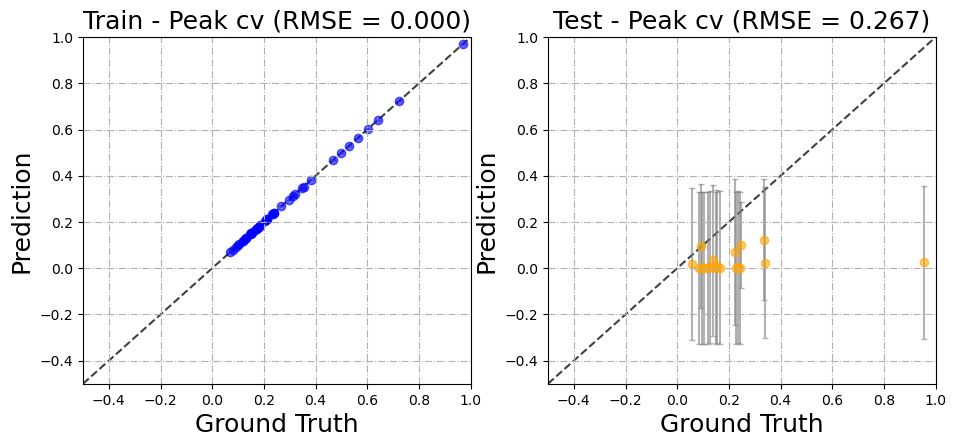

In [74]:
myplot([Train_y,Test_y],[y_pred_train,y_pred_test],[var_train,var_test],
       ["Train - Peak cv","Test - Peak cv"],
       ["blue","orange"],
      [-0.5,1])
#plt.savefig('result',dpi=1000)

In [67]:
X_normalize = x_normalizer(Data[:,:5])
Y_normalize = Data[:,7]/ss_y
m52 = GPy.kern.sde_Matern52(input_dim=5,ARD =True)
rbf =  GPy.kern.RBF(input_dim=5, variance=1., lengthscale=1.,ARD=True)
linear = GPy.kern.Linear(input_dim=5,ARD =True)
m52 = GPy.kern.Matern52(input_dim = 5, ARD =True)
m52.lengthscale.constrain_bounded(1e-2, 1e-1)
m52.variance.constrain_bounded(1e-1, 1000.0)
kernel = m52
model = GPy.models.GPRegression(X_normalize,Y_normalize.reshape(-1,1),kernel)



model.randomize()
model.optimize_restarts(num_restarts = 50)
model.optimize(messages=True)

reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


Optimization restart 1/50, f = 14.294107227317731
Optimization restart 2/50, f = 14.294118812787143
Optimization restart 3/50, f = 14.294126689434602
Optimization restart 4/50, f = 14.29410945091615
Optimization restart 5/50, f = 14.294112737288017
Optimization restart 6/50, f = 14.294116855898135
Optimization restart 7/50, f = 14.29409753133801
Optimization restart 8/50, f = 14.294100319323082
Optimization restart 9/50, f = 14.294113369564212
Optimization restart 10/50, f = 14.294104264641028
Optimization restart 11/50, f = 14.294126748421618
Optimization restart 12/50, f = 14.294105590718665
Optimization restart 13/50, f = 14.294130830666301
Optimization restart 14/50, f = 14.294121296329674
Optimization restart 15/50, f = 14.294100734257555
Optimization restart 16/50, f = 14.294098714000764
Optimization restart 17/50, f = 14.29411156291587
Optimization restart 18/50, f = 14.29410130895064
Optimization restart 19/50, f = 14.29412076372735
Optimization restart 20/50, f = 14.2941111303

3.3627193711943505e-07


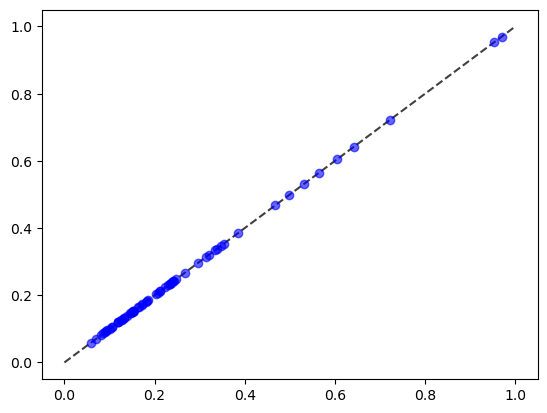

In [68]:
y_pred = model.predict(X_normalize)[0]
plt.scatter(Y_normalize,y_pred,c='b',alpha=0.6)
plt.plot([0,1],[0,1], 'k--', alpha=0.75, zorder=0)
print(mse(Y_normalize,y_pred,squared=False))

In [69]:
parameter_space = ParameterSpace([ContinuousParameter('Tip_Height', 0-1/(Tip_Height_num-1)/2, 1+1/(Tip_Height_num-1)/2),
                                  ContinuousParameter('Dispense_Speed_AS', 0-1/(Dispense_Speed_AS_num-1)/2, 1+1/(Dispense_Speed_AS_num-1)/2),
                                  ContinuousParameter('Spin_Speed', 0-1/(Spin_Speed_num-1)/2, 1+1/(Spin_Speed_num-1)/2),
                                  ContinuousParameter('Volume_AS', 0-1/(Volume_AS_num-1)/2, 1+1/(Volume_AS_num-1)/2),
                                  ContinuousParameter('Timing_AS', 0-1/(Timing_AS_num-1)/2, 1+1/(Timing_AS_num-1)/2)
                                  
                                  ])
parameter_space.parameters

[ContinuousParameter(Tip_Height, -0.005050505050505051, 1.005050505050505),
 ContinuousParameter(Dispense_Speed_AS, -0.010416666666666666, 1.0104166666666667),
 ContinuousParameter(Spin_Speed, -0.007692307692307693, 1.0076923076923077),
 ContinuousParameter(Volume_AS, -0.02, 1.02),
 ContinuousParameter(Timing_AS, -0.03125, 1.03125)]

In [22]:
np.random.seed(1000)

objective_model = GPyModelWrapper(model)
bs = 3


acquisition = NegativeLowerConfidenceBound(objective_model, beta = 1)#NegativeLowerConfidenceBound(objective_model, beta = beta[i])#ExpectedImprovement(objective_model, jitter=.1)#NegativeLowerConfidenceBound(objective_model, beta = 1)

bayesopt= BayesianOptimizationLoop(model=objective_model, 
                                   space=parameter_space, 
                                   acquisition=acquisition,
                                   batch_size = bs)


X_new = bayesopt.candidate_point_calculator.compute_next_points(bayesopt.loop_state)
x = get_closest_array(x_denormalizer(X_new,var_array))
df_Xnew = pd.DataFrame(x, columns = x_label)
u = ss_y*model.predict(x_normalizer(x))[0]
sigma = ss_y*model.predict(x_normalizer(x))[1]
pred = pd.DataFrame(np.append(u,sigma,axis=1),columns=['pred_mean','pred_sigma'])
final = pd.concat([df_Xnew, pred], axis=1)
final


1000000
LPP


 D:\Anaconda\lib\site-packages\emukit-0.4.10-py3.9.egg\emukit\bayesian_optimization\acquisitions\log_acquisition.py:25: RuntimeWarning:invalid value encountered in log


Init point :  [0.46538428 0.14174281 0.2063762  0.79678339 0.13500668]
opt point :  (array([[0.46538428, 0.14174281, 0.2063762 , 0.79678339, 0.13500668]]), array([[nan]]))
acq_max =  [[nan]]
Init point :  [0.2900123  0.80174498 0.14451664 0.0076728  0.25450386]
opt point :  (array([[0.2900123 , 0.80174498, 0.14451664, 0.0076728 , 0.25450386]]), array([[nan]]))
acq_max =  [[nan]]
Init point :  [0.78215543 0.61269504 0.67363696 0.19938139 0.45603455]
opt point :  (array([[0.78215543, 0.61269504, 0.67363696, 0.19938139, 0.45603455]]), array([[nan]]))
acq_max =  [[nan]]


,Tip_Height,Dispense_Speed_AS,Spin_Speed_AS,Volume_AS,Timing_AS,pred_mean,pred_sigma
0,23.5,90.0,1800.0,250.0,4.0,0.000551,2.999982e-11
1,15.0,400.0,1400.0,50.0,6.0,0.001946,1.674707e-04
2,39.0,310.0,4900.0,100.0,9.0,0.000904,9.564855e-05


In [23]:
final.to_excel('Peak cv2_gp.xlsx')

In [70]:
np.random.seed(1000)

objective_model = GPyModelWrapper(model)
bs = 1

beta = [0.1,1,2]
recommend_point = []
num = 3
for i in range(num):

    acquisition = NegativeLowerConfidenceBound(objective_model, beta = beta[i])#NegativeLowerConfidenceBound(objective_model, beta = beta[i])#ExpectedImprovement(objective_model, jitter=.1)#NegativeLowerConfidenceBound(objective_model, beta = 1)

    bayesopt= BayesianOptimizationLoop(model=objective_model, 
                                       space=parameter_space, 
                                       acquisition=acquisition,
                                       batch_size = bs)


    X_new = bayesopt.candidate_point_calculator.compute_next_points(bayesopt.loop_state)

    recommend_point.append(get_closest_array(x_denormalizer(X_new,var_array)))
    
recommend_point_pd = pd.DataFrame(np.array(recommend_point).reshape(-1,5), columns = x_label)

rp = x_normalizer(np.array(recommend_point).reshape(num,5))
u = ss_y*model.predict(rp)[0] #均值
sigma = ss_y*model.predict(rp)[1] #方差
pred = pd.DataFrame(np.append(u,sigma,axis=1),columns=['pred_mean','pred_sigma'])
final = pd.concat([recommend_point_pd, pred], axis=1)
final

1000000
Init point :  [0.96747067 0.03190721 0.04042117 0.34463885 0.96136977]
opt point :  (array([[ 1.00000115e+00, -1.58992554e-03, -6.88938629e-04,
         3.21549964e-01,  1.00098523e+00]]), array([[-0.03629849]]))
acq_max =  [[0.03629849]]
1000000
Init point :  [0.96513787 0.04633729 0.01855794 0.41847219 0.97946128]
opt point :  (array([[ 1.00006988, -0.00359656, -0.00188201,  0.40038048,  1.00242921]]), array([[-0.31778798]]))
acq_max =  [[0.31778798]]
1000000
Init point :  [0.93382003 0.05821821 0.00934218 0.52182505 1.01769601]
opt point :  (array([[ 1.00505051, -0.00978522, -0.00769231,  0.51634564,  1.0105755 ]]), array([[-3.16251616]]))
acq_max =  [[3.16251616]]


,Tip_Height,Dispense_Speed_AS,Spin_Speed_AS,Volume_AS,Timing_AS,pred_mean,pred_sigma
0,50.0,20.0,500.0,130.0,18.0,-0.000018,0.000278
1,50.0,20.0,500.0,150.0,18.0,-0.000008,0.000298
2,50.0,20.0,500.0,180.0,18.0,-0.000001,0.000300


In [71]:
final.to_excel('Peak cv2_gp.xlsx')